### This program outlines a series of steps taken for producing a predicted concentration value from the proto2 sensor

## First step is to load in all of our necessary modules. 
### Pandas and numpy do most of the heavy lifting in this script. Matplotlib is mainly for plotting

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
from datetime import datetime, timedelta, date
from matplotlib.path import Path
import matplotlib.patheffects as pe
import glob,os
import time
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import sys


import warnings
warnings.filterwarnings("ignore")

In [2]:
#get the corrected proto2 filenames

#path_corrected_proto2='/data/aq/inhouse/corrected/csv/'
#path_corrected_proto2='corrected-Sept-Modified/'
path_corrected_proto2='despiked_proto2/'

proto2_corrected_filepaths=[]
for file in sorted(os.listdir(path_corrected_proto2)):
    if file != '.ipynb_checkpoints':
        proto2_corrected_filepaths.append(path_corrected_proto2+file)
    
proto2_corrected_from_files=(pd.read_csv(f,on_bad_lines='skip') for f in proto2_corrected_filepaths)
proto2_corrected=pd.concat(proto2_corrected_from_files)

times=pd.to_datetime(proto2_corrected['Unnamed: 0'],format='%Y-%m-%d %H:%M:%S')
proto2_corrected=proto2_corrected.set_index(times)
proto2_corrected.index.names=['date']
proto2_corrected=proto2_corrected.drop('Unnamed: 0',1)
proto2_corrected;

### Resampling the high frequency proto2 data into hour averages so that it's compatible with hourly observations

In [3]:
#take high frequency proto2 data and resample to hourly mean
houravg=proto2_corrected.drop(columns=['datetimestamp']).apply(pd.to_numeric).resample('60min').mean()

### Pulling in observed gas concentrations from DEC. This was acquired using the EPA API

In [4]:
#get the epa filenames

path_epa='/data/aq/DEC/csv/'

epa_filepaths=[]
for file in sorted(os.listdir(path_epa)):
    epa_filepaths.append(path_epa+file)

In [5]:
epa_from_files=(pd.read_csv(f) for f in epa_filepaths)
epa_df=pd.concat(epa_from_files)
epa_df=epa_df.set_index(pd.to_datetime(epa_df['date']))

### Define some dictionaries that tie the concentration number code to its appropriate name

In [6]:
#set dictionary that matches varid to field name
proto2_table={'42101':'CO_ppb','44201':'O3NO2_ppb','42601':'NO_ppb','42602':'NO2_ppb','88101':'pm25'}
epa_table={42101:'Trace CO (ppb)',44201:'O3 (ppb)',42601:'NOx (ppb)',42602:'NO2 (ppb)',88101:'PM25FEM (ug/m3)'}

### Toss out times in the DEC observations where there is no recorded data in proto2

In [7]:
epa_df_matching_proto2=epa_df.loc[epa_df.index.isin(houravg.index)]
epa_df_matching_proto2;

### Now prepare the input data and perform the regression

In [8]:
# Select date ranges corresponding to months 
july = (epa_df_matching_proto2['date'] >= '2021-07-01  00:00:00') & (epa_df_matching_proto2['date'] <= '2021-07-31 23:00:00') 
august = (epa_df_matching_proto2['date'] >= '2021-08-01  00:00:00') & (epa_df_matching_proto2['date'] <= '2021-08-31 23:00:00') 
september = (epa_df_matching_proto2['date'] >= '2021-09-01  00:00:00') & (epa_df_matching_proto2['date'] <= '2021-09-31 23:00:00') 
october = (epa_df_matching_proto2['date'] >= '2021-10-01  00:00:00') & (epa_df_matching_proto2['date'] <= '2021-10-31 23:00:00') 
november = (epa_df_matching_proto2['date'] >= '2021-11-01  00:00:00') & (epa_df_matching_proto2['date'] <= '2021-11-31 23:00:00') 
#month_dict = {'July':july, 'August':august, 'September':september, 'October':october, 'November':november}

## Apply Regression

### Generate regression coefficients script 

In [9]:
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures

import statsmodels.api as sm
from scipy import stats
import statistics

import warnings
warnings.filterwarnings("ignore")

def generate_coefficients(training_predictors, training_reference_concentrations, method):
    '''
    INPUT...
    training_predictors = list of dataframe corresponding of predictors in training period 
    training_reference_concentrations = dataframe containing reference concentrations (DEC) during training period
    
    method = 'linear' or 'quadratic' (only LINEAR works as of 02/08/2023)    
    ===========================================================
    RETURNS...
    00 = coefficient + y-intercepts of regression equation as a dictionary (this is what's important!)
    01 = model (kept for documentation purposes)
    '''
    
    training_predictor_fields=pd.concat(training_data,axis=1)    
    training_sensor_field=training_reference_concentrations
    
    if method == 'linear':
        # apply regression
        reg = LinearRegression()
        model = reg.fit(training_predictor_fields.values, training_sensor_field.values)
        
        # coefficient dictionary
        coefs=model.coef_
        coef_dict={}
        for num_of_coefs in range(len(model.coef_)):
            coef_dict[str(num_of_coefs).zfill(2)]=coefs[num_of_coefs]
        coef_dict['intercept']=model.intercept_
    
    # QUADRATIC IS UNFINISHED 
    if method == 'quadratic':
        # apply regression
        poly = PolynomialFeatures(degree=2, include_bias=False)
        poly_features = poly.fit_transform(training_predictor_fields.reshape(-1,10))
        poly_reg_model = LinearRegression()

        model = poly_reg_model.fit(training_predictor_fields.values, training_sensor_field.values)
        
        # coefficient dictionary
        coefs=reg.coef_
        coef_dict={}
        for num_of_coefs in range(len(reg.coef_)):
            coef_dict[str(num_of_coefs).zfill(2)]=coefs[num_of_coefs]
        coef_dict['intercept']=reg.intercept_


    return coef_dict

### Calibrate script

In [10]:
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

import statsmodels.api as sm
from scipy import stats
import statistics

import warnings
warnings.filterwarnings("ignore")

# remove testing_reference_concentrations

def calibrate(coef_dict,testing_predictors,testing_reference_concentrations):
    '''
    INPUT...
    coef_dict = coefficient dictionary returned from generate_coefficients function
    testing_predictors = list of dataframe corresponding of predictors in testing period 
    testing_reference_concentrations = dataframe containing reference concentrations (DEC) during testing period
        
    ===========================================================
    RETURNS...
    00 = calibrated data as an array 
    01 = performance metrics aka stats 
          --> r-squared 
          --> m and slope from fitting the reference data (x) against the calibrated data (y)
          --> RMSE using sklearn module
          --> z-score mean and array 
          --> still need to add: % bias, t-test, and p-value 
    '''
    
    intercept = coef_dict['intercept'] 
    del coef_dict['intercept']
    
    #print('\nIntercept = ', intercept)

    calibrated_data = intercept 

    for coefficients in range(len(coef_dict)):
        if coefficients < 10: 
            coefficient = coef_dict['0'+str(coefficients)] # access each coefficient
        else:        
            coefficient = coef_dict[str(coefficients)] # access each coefficient
    
        #print('Calibrating w/ coefficient = ',testing_predictors[coefficients].name)
        #print('  ... value of coefficient = ',coefficient)
            
        calibrated_data += coefficient*testing_predictors[coefficients] # recursive function
    
    coef_dict['intercept'] = intercept
    
    # generate statisitics 
    n=len(testing_reference_concentrations)
    r2=(((n*(calibrated_data*testing_reference_concentrations).sum())-(calibrated_data.sum()*testing_reference_concentrations.sum()))\
        /np.sqrt((n*(testing_reference_concentrations**2).sum()-(testing_reference_concentrations).sum()**2)*\
                 (n*(calibrated_data**2).sum()-calibrated_data.sum()**2)))**2
    
    m = np.polyfit(testing_reference_concentrations,calibrated_data,1) 
    z_score_array = np.array((calibrated_data-calibrated_data.mean())/statistics.stdev(calibrated_data))
            
    stats_dict={} 
    stats_dict['r2'] = r2_score(testing_reference_concentrations,calibrated_data)
    stats_dict['m'] = m[0]
    stats_dict['m_y-int'] = m[1]
    stats_dict['RMSE'] = sqrt(mean_squared_error(calibrated_data, testing_reference_concentrations)) 
    stats_dict['z-score_mean'] = z_score_array.mean()
    stats_dict['z-score_array'] = z_score_array
    stats_dict['r2_hardcoded'] = r2
    stats_dict['percent_bias'] = ((testing_reference_concentrations.mean()-calibrated_data.mean())/(abs(testing_reference_concentrations.mean())))*100

    
    #print('\n')
    return calibrated_data, stats_dict

### Looping through all months for all pollutants

In [11]:
#the observed concentrations and proto2 data are using different timezones. apply a 5 hour fix to shift them over
#long term it may be wise to just correct proto2 data and rewrite it as a file
tshift=5

#specify the method you want for the regression
method='linear'

#define an empty dictionary to hold output
r2_dict = {}
m_dict = {}
RMSE_dict = {}
month_data = {} 

vd={}
model_directory = {}

# create dataframes to hold model performance stats, we will create plots using these later
model_stats=['r²','Slope (m)','RMSE','Percent Bias','Training Period']

CO_stats_df = pd.DataFrame(columns=model_stats)
O3_stats_df = pd.DataFrame(columns=model_stats)
NO_stats_df = pd.DataFrame(columns=model_stats)
NO2_stats_df = pd.DataFrame(columns=model_stats)
pm25_stats_df = pd.DataFrame(columns=model_stats)

# CO:42101  O3NO2:44201  NO:42601  NO2:42602 PM2.5:88101
#for var_id in [42101, 44201, 42601, 42602, 88101]

month_str_dict = {7:'July', 8:'August', 9:'September', 10:'October', 11:'November'}
pollutant_stats_df_dict = {42101:CO_stats_df,44201:O3_stats_df,42601:NO_stats_df,42602:NO2_stats_df,88101:pm25_stats_df}

training_periods = [7,8,9,10,11]

In [12]:
for var_id in [42101, 44201, 42601, 42602, 88101]:
#for var_id in [42101]:

    for training_month in training_periods: 
    
    #for var_id in [42101, 44201, 42601, 42602, 88101]:
    #for var_id in [42101]:


        #get the concentration field that matches the corresponding var_id from observations and convert the time (here it's just a 5 hour conversion)
        if var_id==44201:
            epa_concentration_field=epa_df_matching_proto2[epa_table[var_id]].rename('value')
            epa_concentration_field.index=epa_concentration_field.index+timedelta(hours=tshift)

        else:
            epa_concentration_field=epa_df_matching_proto2[epa_table[var_id]].rename('value')
            epa_concentration_field.index=epa_concentration_field.index+timedelta(hours=tshift)


        #combine the observations and proto2 data into one dataset
        combined_df=pd.concat([epa_concentration_field,houravg],axis=1).dropna()

        #include some checks to see if the field is O3 or pm2.5
        #O3 needs to subtract NO2 because the sensor only records O3NO2
        #pm2.5 has a weird naming convention so this statement catches it and renames it to be consistent
        #basically we're just calculating the voltage difference here
        if var_id==44201:
            combined_df['O3_voltdiff']=(combined_df['O3NO2_V']-combined_df['NO2_V']).sub((combined_df['O3NO2_aux_V']-combined_df['NO2_aux_V']),axis=0)
            gname='O3'
            unit = '_ppb'
            pltunit = 'ppb'

        elif var_id in [88101]:
            gname='pm25'
            combined_df[gname+'_voltdiff']=combined_df[gname+'_std_ugm3'].copy()
            unit='_env_ugm3'
            pltunit = 'ug/m³'

        else:
            fname=proto2_table[str(var_id)]
            gname_loc=fname.find('ppb')-1
            gname=fname[:gname_loc]

            combined_df[gname+'_voltdiff']=combined_df[gname+'_V'].sub(combined_df[gname+'_aux_V'],axis=0)
            unit = '_ppb'
            pltunit = 'ppb'


        # perform some additional last minute qc on the data
        # this just tosses out times where the obs data is weird (i.e. is nan, ==0, ==-999, >10*mean)
        combined_df_filtered=combined_df.loc[(~np.isnan(combined_df['value'])) & (combined_df['value']>0) 
                                             & (combined_df['value']!=0) & (combined_df['value']!=-999) 
                                             & (abs(combined_df['value'])<(abs(combined_df['value']).mean()*10))]
        # some fun time predictors 
        combined_df_filtered['decimal_day'] = combined_df_filtered.index.dayofyear # create a column for decimal day; aka time predictor 

        combined_df_filtered['dayofweek'] = combined_df_filtered.index.dayofweek # creates column of weekday numbers 
        combined_df_filtered.loc[combined_df_filtered['dayofweek'] <= 4, 'weekday_binary'] = 1 # converts weekdays to 0 (if Zamora, now 1) 
        combined_df_filtered.loc[combined_df_filtered['dayofweek'] > 4, 'weekday_binary'] = 0 # converts weekends to 1 (if Zamora, now 0) 

        daylight_mask = (combined_df_filtered.index >= '06:00:00') & (combined_df_filtered.index  <= '23:00:00') # delinate daytime
        combined_df_filtered.loc[daylight_mask, 'daylight_hours_binary'] = 1 # converts daytime to 1
        combined_df_filtered['daylight_hours_binary'] = combined_df_filtered['daylight_hours_binary'].fillna(0) # nighttime is 0

        # delineate training and test periods 
        #combined_df_filtered_training=combined_df_filtered.loc[august]
        training_period = combined_df_filtered.loc[combined_df_filtered.index.month == training_month]

        #combined_df_filtered_testing=combined_df_filtered.loc[july+october+september+november]
        testing_period = combined_df_filtered.loc[combined_df_filtered.index.month != training_month] # removes training period from testing period 


        # training fields using proto2_QC.csv 
        training_reference_concentrations = training_period['value']
        training_data = [training_period['temp_sht31_degC'], # T
                         training_period['temp_sht31_degC']**2, # T^2
                         training_period['rh_sht31_percent'], # RH
                         training_period['temp_sht31_degC']*training_period['rh_sht31_percent'], # T-RH interaction
                         training_period['temp_sht31_degC']*training_period[gname+'_voltdiff'], # T-sensor interaction
                         training_period[gname+'_voltdiff'], # sensor
                         training_period['weekday_binary']]  # binary weekend
                         #combined_df_filtered_training['decimal_day']] # decimal day

        # testing fields using proto2_QC.csv 
        testing_reference_concentrations = testing_period['value']
        testing_data = [testing_period['temp_sht31_degC'], # T
                        testing_period['temp_sht31_degC']**2, # T^2
                        testing_period['rh_sht31_percent'], # RH
                        testing_period['temp_sht31_degC']*testing_period['rh_sht31_percent'], # T-RH interaction
                        testing_period['temp_sht31_degC']*testing_period[gname+'_voltdiff'], # T-sensor interaction
                        testing_period[gname+'_voltdiff'],  # sensor
                        testing_period['weekday_binary']] # binary weekend
                        #combined_df_filtered_testing['decimal_day']] # decimal day

        model = gname+'_model'
        model_name = gname+'_model'

        print('Training period = ', month_str_dict[training_month])
        print('Generating coefficients for ', gname,'...')
        model = generate_coefficients(training_data,training_reference_concentrations, method='linear')

        print('Calibrating for ', gname,'...')
        calibrated_data = calibrate(model,testing_data,testing_reference_concentrations)
        model_perf = calibrated_data[1]
        calibrated_data = calibrated_data[0]

        testing_period_plt = testing_reference_concentrations.index

        model_directory[model_name] = model
        
        '''Appending model performance stats to dictionaries ''' 
        pollutant_dict = {42101:'CO_model_stats',44201:{'O3_model_stats'},42601:{'NO_model_stats'},42602:{'NO2_model_stats'},88101:{'pm25_model_stats'}}
        

        ''' PLOT TIME :) '''
        print('Plotting for ',gname,'...')
    
        fig = plt.subplots(figsize=(10,8))

        ''' DEC vs. Calibrated time series plot (top) '''
        time_series = plt.subplot2grid((3, 3), (0, 0), rowspan=2, colspan=3)
        time_series.set_title('time_series')
        time_series.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
        time_series.plot(testing_period_plt,testing_reference_concentrations,label='DEC data', color='black',linewidth=0.55)
        time_series.plot(testing_period_plt,calibrated_data,label='Linear calibrated', color='red',linewidth=0.45)
        time_series.legend()  
        time_series.set_title('2021 Proto2 Dataset '+gname+' Regression Calibration Results | Training Period = '+month_str_dict[training_month], fontsize=10)
        time_series.set_xlabel('Date')
        time_series.set_ylabel('Proto2 Concentration ' +'('+pltunit+')')

        ''' DEC vs. Calibrated trend  plot (bottom left) '''
        data_series = plt.subplot2grid((3, 3), (2, 0), colspan=2)
        data_series.set_title('data_series')
        data_series.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
        # 1:1 line
        if var_id==42101: # CO
            xmax = 2000
        if var_id==44201: # O3
            xmax = 200
        if var_id==42601: # NO
            xmax = 200
        if var_id==42602: # N02
            xmax = 70
        if var_id==88101: # pm25
            xmax = 80 
        ymax=xmax
        point1 = [0,0]
        point2 = [xmax,ymax]
        x_values = [point1[0], point2[0]]
        y_values = [point1[1], point2[1]]
        data_series.plot(x_values, y_values, color='black', label='1:1 Line')
        # plotting data... 
        data_series.scatter(testing_reference_concentrations,calibrated_data,color='red',s=0.25)
        data_series.set_xlabel('DEC Reference Concentration '+'('+pltunit+')')
        data_series.set_ylabel('Proto2 Concentration ' +'('+pltunit+')')
        data_series.set_title('Reference Data vs. Calibrated Proto2', fontsize=10)

        ''' Regression Coefficient Table (bottom right) '''
        # create dataframe of table data 
        table_data = pd.DataFrame()
        table_data = table_data.append(model,ignore_index=True)
        table_data = table_data.transpose()
        table_data = table_data.rename(columns = {0:'Coefficient'}, index={"00": "T", '01':'T²', '02':'RH','03':'T*RH','04':'T*VoltDiff',
                        '05':'VoltDiff','06':'Weekday Binary','intercept':'Y-Intercept'})
        table_data = table_data.reindex((table_data.abs().sort_values(by=['Coefficient'], ascending=False)).index) # sorts table by highest abs value of coefficient 
        table_data = table_data.round(3) # rounding coefficients to 3 decimal places 
    
        ''' Regression Coefficient Table '''
        table = plt.subplot2grid((3, 3), (2, 2))
        table.text(-0.0912,0.067,'Regression Coefficients Table')
        #hide the axes
        table.patch.set_visible(False)
        table.axis('off')
        table.axis('tight')
        regression_table = table.table(cellText=table_data.values, rowLabels=table_data.index, loc='center')
        regression_table.scale(0.5,1.5)
        regression_table.set_fontsize(10)
        table.text(0.2,-0.2, 'Linear... r²= '+str(round(model_perf['r2_hardcoded'],2))+' |  m= '+str(round(model_perf['m'],2))+' |  RMSE = '+str(round(model_perf['RMSE'],0)), 
                   horizontalalignment='center', verticalalignment='center', transform=table.transAxes, color='red', fontsize=8)
    
        if model_perf['r2'] < 0: 
            print('negative r² detected! --> ', model_perf['r2'])
        if abs(model_perf['r2']) > 1: 
            print('r² >> | 1 | detected! --> ', model_perf['r2'])

        # Adjust layout to make room for the table:
        plt.subplots_adjust(left=0, wspace=0.75, hspace=0.50)        
        savefig_as = gname+'_'+month_str_dict[training_month]+'_training-period'
        #plt.savefig('/data/shared/ehojeily/trainingperiod-testing/hardcoded-r2-monthly-linear-analysis-plots/'+savefig_as+'.png',bbox_inches='tight',dpi=300)
        print('r2_score = ', model_perf['r2'])
        print('r2_hardcoded = ', model_perf['r2_hardcoded'])
        print('\n')
        plt.close()
        
        pollutant_stats_df_dict[var_id] = pollutant_stats_df_dict[var_id].append({'r²':model_perf['r2_hardcoded'],'Slope (m)':model_perf['m'],
                                                                'RMSE':model_perf['RMSE'],'Percent Bias':model_perf['percent_bias'],
                                                                                  'Training Period':month_str_dict[training_month]}, ignore_index=True)

Training period =  July
Generating coefficients for  CO ...
Calibrating for  CO ...
Plotting for  CO ...
r2_score =  0.7597942568344076
r2_hardcoded =  0.8498088098272848


Training period =  August
Generating coefficients for  CO ...
Calibrating for  CO ...
Plotting for  CO ...
r2_score =  0.9174690607737949
r2_hardcoded =  0.9403472011327993


Training period =  September
Generating coefficients for  CO ...
Calibrating for  CO ...
Plotting for  CO ...
r2_score =  0.9245645909328678
r2_hardcoded =  0.9365069996461943


Training period =  October
Generating coefficients for  CO ...
Calibrating for  CO ...
Plotting for  CO ...
r2_score =  0.9208958008364876
r2_hardcoded =  0.9271976473186073


Training period =  November
Generating coefficients for  CO ...
Calibrating for  CO ...
Plotting for  CO ...
negative r² detected! -->  -0.09500623298252897
r2_score =  -0.09500623298252897
r2_hardcoded =  0.7597226003605126


Training period =  July
Generating coefficients for  O3 ...
Calibrating

## readme.txt maker for directories 

with open('/data/shared/ehojeily/calibrate-function-testing/predict_T-TSQRD-RH-TRH-TVOLT-VOLT-DAYLIGHTBIN-WEEKDAYBIN-DECIMAL-DAY-NOVONLY/readme.txt', 'w') as f:
    f.write('Testing new calibrate function...\n Predictors used: Temperature, Temperature-squared, RH, T-RH interaction, T-voltage difference, voltage difference, weekday binary (1 if weekday, 0 if weekend), daylight binary (1 if between 6 Z and 23 Z, 0 if else), and time (decimal day) \n Training period: August, Testing period: July, Sept-Nov \n Script used: loop_test_allConcentrations.ipynb')

In [1]:
#var_id_2_name={42101:'CO (ppb)',44201:'O3 (ppb)',42601:'NO (ppb)',42602:'NO2 (ppb)',88101:'pm2.5 (ug/m³)'}
#for var_id in [42101, 44201, 42601, 42602, 88101]:
    #plt.plot(pollutant_stats_df_dict[var_id]['Training Period'],pollutant_stats_df_dict[var_id]['r²'], label=var_id_2_name[var_id])
    #plt.legend()

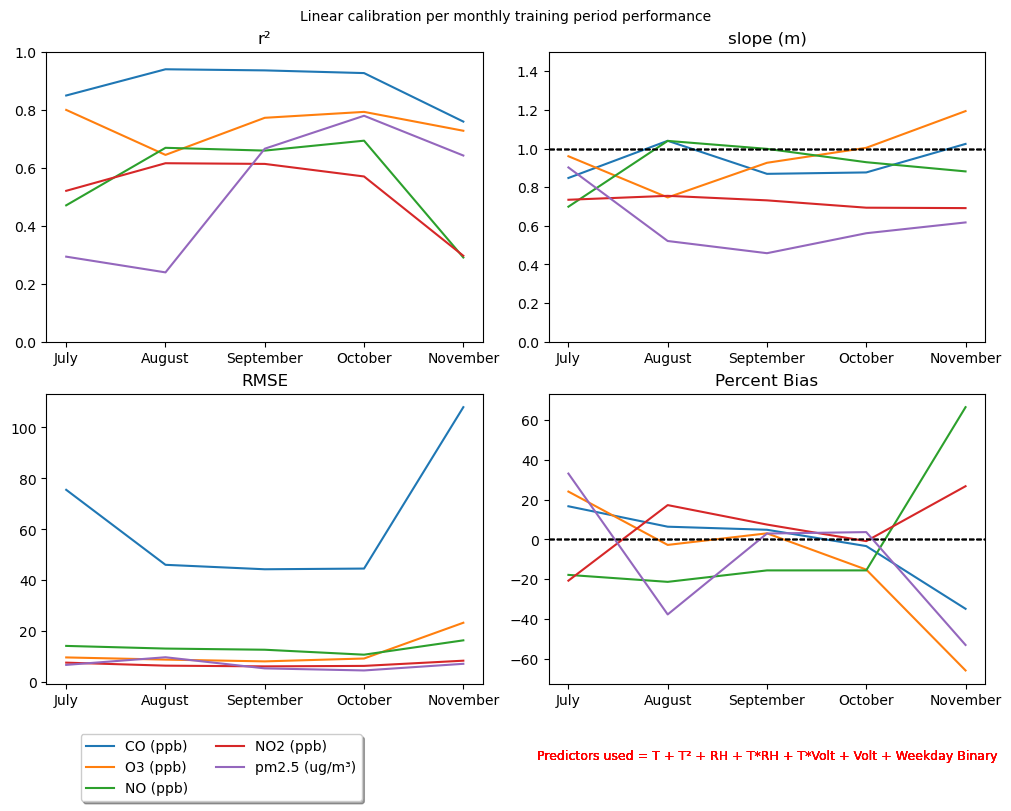

In [15]:
''' Monthly stat breakdown '''
fig = plt.subplots(figsize=(10,8), layout='constrained')
plt.suptitle('Linear calibration per monthly training period performance', fontsize=10)

r2_analysis = plt.subplot2grid((2, 2), (0, 0))
m_analysis = plt.subplot2grid((2, 2), (0, 1))
rmse_analysis = plt.subplot2grid((2, 2), (1, 0))
percentbias_analysis = plt.subplot2grid((2, 2), (1, 1))
predictors = ['T', 'T²', 'RH', 'T*RH', 'T*Volt', 'Volt', 'Weekday Binary']


var_id_2_name={42101:'CO (ppb)',44201:'O3 (ppb)',42601:'NO (ppb)',42602:'NO2 (ppb)',88101:'pm2.5 (ug/m³)'}
for var_id in [42101, 44201, 42601, 42602, 88101]:
    r2_analysis.plot(pollutant_stats_df_dict[var_id]['Training Period'],pollutant_stats_df_dict[var_id]['r²'], label=var_id_2_name[var_id])
    r2_analysis.set_ylim(0,1)
    r2_analysis.set_title('r²')
    
    m_analysis.plot(pollutant_stats_df_dict[var_id]['Training Period'],pollutant_stats_df_dict[var_id]['Slope (m)'], label=var_id_2_name[var_id])
    m_analysis.axhline(y = 1, color = 'black', linestyle = '--', linewidth=1) # indicate slope of 1 / 1:1 line
    m_analysis.set_ylim(0,1.5)
    m_analysis.set_title('slope (m)')
    
    rmse_analysis.set_title('RMSE')
    rmse_analysis.plot(pollutant_stats_df_dict[var_id]['Training Period'],pollutant_stats_df_dict[var_id]['RMSE'], label=var_id_2_name[var_id])
    rmse_analysis.legend(loc='upper center', bbox_to_anchor=(0.4,-0.15),
              ncol=2, fancybox=True, shadow=True)
    
    percentbias_analysis.set_title('Percent Bias')
    percentbias_analysis.plot(pollutant_stats_df_dict[var_id]['Training Period'],pollutant_stats_df_dict[var_id]['Percent Bias'], label=var_id_2_name[var_id])
    percentbias_analysis.axhline(y = 0, color = 'black', linestyle = '--', linewidth=1) # indicate slope of 1 / 1:1 line
    
    ''' for use in creating predictor list in plots '''
    predictor_text = ''
    for predictor in predictors: 
        if predictor != predictors[-1]:
            predictor_text += predictor+' + '
        else: 
            predictor_text += predictor

    percentbias_analysis.text(0.50, -0.25, 'Predictors used = '+predictor_text, horizontalalignment='center',
             verticalalignment='center', transform=percentbias_analysis.transAxes, color='red', fontsize=9) 
'''
plt.savefig('/data/shared/ehojeily/trainingperiod-testing/model_analysis_quadplots/r2_slope_rmse_percentbias.png',bbox_inches='tight',dpi=300)
with open('/data/shared/ehojeily/trainingperiod-testing/model_analysis_quadplots/readme.txt', 'w') as f:
    f.write('Model performance when data are trainined for one month and tested against the remaining months. \n Script used: monthly_reg_plots.ipynb')
'''